# 0. 패키지 로드

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

print("LightGBM version:", lgb.__version__)

LightGBM version: 4.6.0


# 1. 데이터 로드 & 전처리

In [2]:
cust_df = pd.read_csv('/Users/kenny/데싸4기/kaggle_datasets/train_santender.csv')      # 경로 확인

median_var3 = cust_df.loc[cust_df['var3'] != -999999, 'var3'].median() # -999999값을 중앙값으로 대체
cust_df.loc[cust_df['var3'] == -999999, 'var3'] = median_var3

y = cust_df['TARGET']
X = cust_df.drop(['ID', 'TARGET'], axis=1, errors='ignore') # 피쳐 타겟 분리

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. 클래스 불균형 가중치

In [3]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum() # 클래스 불균형 보정

# 3. LightGBM 학습 ­– “호환 100%” 최소 파라미터만 사용

In [4]:
model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=600,         # early-stopping 없이도 과적합 적은 범위
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)   # ← 추가 인자 없음

[LightGBM] [Info] Number of positive: 2406, number of negative: 58410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14286
[LightGBM] [Info] Number of data points in the train set: 60816, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039562 -> initscore=-3.189521
[LightGBM] [Info] Start training from score -3.189521


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=600,
               n_jobs=-1, num_leaves=64, objective='binary', random_state=42,
               scale_pos_weight=24.276807980049874, subsample=0.8)

# 4. 검증 ROC-AUC

In [5]:
val_pred = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, val_pred)
print(f"Validation ROC-AUC: {roc_auc:.4f}")

Validation ROC-AUC: 0.8134


# 5. 상위 20개 피처 중요도 그래프

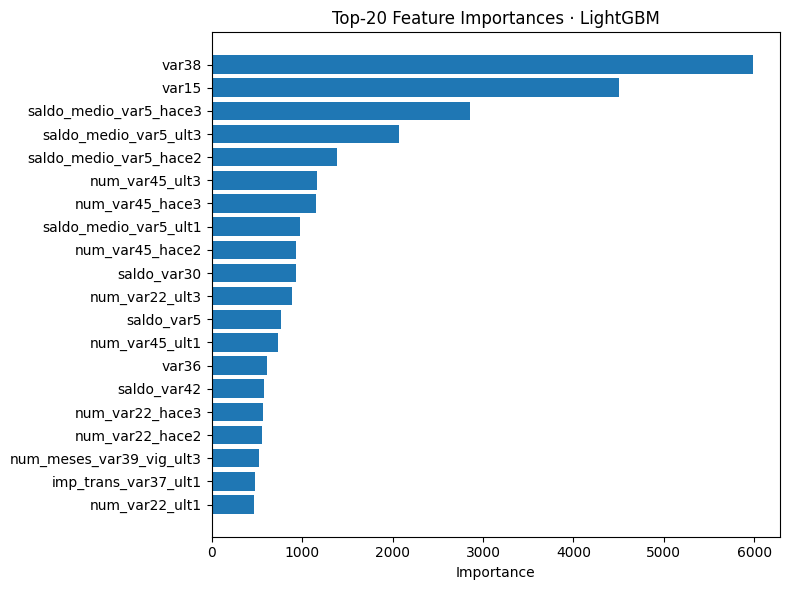

In [6]:
importances = model.feature_importances_
top_idx = np.argsort(importances)[-20:]
plt.figure(figsize=(8, 6))
plt.barh(range(len(top_idx)), importances[top_idx])
plt.yticks(range(len(top_idx)), X.columns[top_idx])
plt.xlabel("Importance")
plt.title("Top-20 Feature Importances · LightGBM")
plt.tight_layout()
plt.show()

.